In [22]:
# Load library
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

## Import Data 

In [2]:
# Create URL
test_csv_2 = "C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_test.csv"
train_csv_2 = "C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_train.csv"

# Load Dataset 
test_df = pd.read_csv(test_csv_2)
train_df = pd.read_csv(train_csv_2)

In [3]:
X_train = train_df[['n_steps', 'n_ingredients']]
y = train_df['duration_label']

In [4]:
import scipy
X_train_name = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_name_vec.npz')
X_test_name = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\test_name_vec.npz')

X_train_step = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_steps_vec.npz')
X_test_step = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\test_steps_vec.npz')

X_train_ingr = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_ingr_vec.npz')
X_test_ingr = scipy.sparse.load_npz('C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\test_ingr_vec.npz')

In [23]:
name_vectorizer = pickle.load(open("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_name_countvectorizer.pkl", "rb"))

c:\users\kenne\python\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Select Features with CountVec and Mutual Information

In [5]:
# Feature Selection with Mutual Information for 'name'
k = 1000
mi = SelectKBest(score_func=mutual_info_classif, k=k)
name_train_mi = mi.fit_transform(X_train_name,y)
name_test_mi = mi.transform(X_test_name)

In [6]:
# Feature Selection with Mutual Information for 'steps'
mi = SelectKBest(score_func=mutual_info_classif, k=k)
step_train_mi = mi.fit_transform(X_train_step,y)
step_test_mi = mi.transform(X_test_step)

In [7]:
# Feature Selection with Mutual Information for 'ingr'
mi = SelectKBest(score_func=mutual_info_classif, k=k)
ingr_train_mi = mi.fit_transform(X_train_ingr,y)
ingr_test_mi = mi.transform(X_test_ingr)

### Merging Features for Training Data

In [8]:
new_train_df = train_df.copy()
new_train_df = new_train_df[['n_steps','n_ingredients']]

In [9]:
name_matrix = name_train_mi.todense()
name_list = name_matrix.tolist()
name_df = pd.DataFrame(name_list)
name_df = name_df.add_prefix('name_')

step_matrix = step_train_mi.todense()
step_list = step_matrix.tolist()
step_df = pd.DataFrame(step_list)
step_df = step_df.add_prefix('step_')

ingr_matrix = ingr_train_mi.todense()
ingr_list = ingr_matrix.tolist()
ingr_df = pd.DataFrame(ingr_list)
ingr_df = ingr_df.add_prefix('ingr_')

In [10]:
# Add name, step and ingr from countvec to new_train_df, name the df features_train
features_train = new_train_df.join(name_df)
features_train = features_train.join(step_df)
features_train = features_train.join(ingr_df)

In [13]:
countvec_train = features_train.copy()

### Test data

In [11]:
new_test_df = test_df.copy()
new_test_df = new_test_df[['n_steps','n_ingredients']]

name_matrix_test = name_test_mi.todense()
name_list_test = name_matrix_test.tolist()
name_df_test = pd.DataFrame(name_list_test)
name_df_test = name_df_test.add_prefix('name_')

step_matrix_test = step_test_mi.todense()
step_list_test = step_matrix_test.tolist()
step_df_test = pd.DataFrame(step_list_test)
step_df_test = step_df_test.add_prefix('step_')

ingr_matrix_test = ingr_test_mi.todense()
ingr_list_test = ingr_matrix_test.tolist()
ingr_df_test = pd.DataFrame(ingr_list_test)
ingr_df_test = ingr_df_test.add_prefix('ingr_')

# Add name, step and ingr from countvec to new_test_df, name the df features_test
features_test = new_test_df.join(name_df_test)
features_test = features_test.join(step_df_test)
features_test = features_test.join(ingr_df_test)

## Doc2Vec100 (does not increase accuracy, leave it out)

In [14]:
# Load Doc2Vec100 Dataset 
train_name_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\train_name_doc2vec100.csv", header=None)
test_name_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\test_name_doc2vec100.csv", header=None)
train_steps_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\train_steps_doc2vec100.csv", header=None)
test_steps_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\test_steps_doc2vec100.csv", header=None)
train_ingr_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\train_ingr_doc2vec100.csv", header=None)
test_ingr_doc100 = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec100\\recipe_text_features_doc2vec100\\test_ingr_doc2vec100.csv", header=None)

In [15]:
# join all Doc2Vec data to features_train, name the new df "features_train_doc100"
train_name_doc100 = train_name_doc100.add_suffix('name_doc2vec')
feature_train_doc100 = features_train.join(train_name_doc100)
train_steps_doc100 = train_steps_doc100.add_suffix('step_doc2vec')
feature_train_doc100 = feature_train_doc100.join(train_steps_doc100)
train_ingr_doc100 = train_ingr_doc100.add_suffix('ingr_doc2vec')
feature_train_doc100 = feature_train_doc100.join(train_ingr_doc100)

In [16]:
# join all Doc2Vec data to features_test, name the new df "features_test_doc100"
test_name_doc100 = test_name_doc100.add_suffix('name_doc2vec')
feature_test_doc100 = features_test.join(test_name_doc100)
test_steps_doc100 = test_steps_doc100.add_suffix('step_doc2vec')
feature_test_doc100 = feature_test_doc100.join(test_steps_doc100)
test_ingr_doc100 = test_ingr_doc100.add_suffix('ingr_doc2vec')
feature_test_doc100 = feature_test_doc100.join(test_ingr_doc100)

## Doc2Vec50

In [42]:
# Load Doc2Vec50 Dataset 
train_name_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\train_name_doc2vec50.csv", header=None)
test_name_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\test_name_doc2vec50.csv", header=None)
train_steps_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\train_steps_doc2vec50.csv", header=None)
test_steps_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\test_steps_doc2vec50.csv", header=None)
train_ingr_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\train_ingr_doc2vec50.csv", header=None)
test_ingr_tot = pd.read_csv("C:\\Users\\kenne\\recipe-cooktime-predictor data\\COMP30027_2021_Project2_datasets\\recipe_text_features_doc2vec50\\recipe_text_features_doc2vec50\\test_ingr_doc2vec50.csv", header=None)

In [43]:
# join all Doc2Vec50 data to features_train, name the new df "features_train_tot"
train_name_tot = train_name_tot.add_suffix('name_doc2vec_50')
feature_train_tot = features_train.join(train_name_tot)
train_steps_tot = train_steps_tot.add_suffix('step_doc2vec_50')
feature_train_tot = feature_train_tot.join(train_steps_tot)
train_ingr_tot = train_ingr_tot.add_suffix('ingr_doc2vec_50')
feature_train_tot = feature_train_tot.join(train_ingr_tot)

In [44]:
# join all Doc2Vec50 data to features_test, name the new df "features_test_tot"
test_name_tot = test_name_tot.add_suffix('name_doc2vec_50')
feature_test_tot = features_test.join(test_name_tot)
test_steps_tot = test_steps_tot.add_suffix('step_doc2vec_50')
feature_test_tot = feature_test_tot.join(test_steps_tot)
test_ingr_tot = test_ingr_tot.add_suffix('ingr_doc2vec_50')
feature_test_tot = feature_test_tot.join(test_ingr_tot)

In [45]:
# Split the training set into train and test set
X_train_tot_split, X_test_tot_split, y_train_tot_split, y_test_tot_split = train_test_split(feature_train_tot, y, test_size=0.33, random_state=88)

# Model using Logistic Regression

In [45]:
lgr = LogisticRegression(C=0.01, solver='sag')
lgr.fit(feature_train_tot, y)
ybar = lgr.predict(feature_test_tot)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [46]:
test_id = test_df.index
data = {'id': test_id+1, 'duration_label': ybar}
df = pd.DataFrame(data)
df.to_csv('predict.csv', index=False)
acc = lgr.score(X_test_tot_split, y_test_tot_split)
print("Accuracy:",acc)
y_pred = lgr.predict(X_test_tot_split)
print("f1 score:", f1_score(y_test_tot_split, y_pred, average='micro'))

Accuracy: 0.8253787878787879
f1 score: 0.8253787878787879


# ----------------------------------------------------------------------------------------------------------

In [14]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(countvec_train, y, test_size=0.33, random_state=88)

## Selecting Features with Chi-Square

In [25]:
from sklearn.feature_selection import SelectKBest, chi2

k=10
x2 = SelectKBest(chi2, k=k)
x2.fit(name_df,y)
X_train_x2 = x2.transform(name_df)
X_test_x2 = x2.transform(name_df_test)

In [26]:
lgr = LogisticRegression()
lgr.fit(X_train_x2, y)
acc = lgr.score(X_train_x2, y)
print("Accuracy:",acc)
y_pred = lgr.predict(X_train_x2)
print("f1 score:", f1_score(y, y_pred, average='micro'))

for feat_num in x2.get_support(indices=True):
    print(name_vectorizer.get_feature_names()[feat_num])

Accuracy: 0.549675
f1 score: 0.549675
1995
abaco
acadia
afghani
aigo
ail
badun
balsalmic
banana
bashed


## Selecting Features with Mutual Information

In [58]:
k=1000
mi = SelectKBest(score_func=mutual_info_classif, k=k)
mi.fit(name_df,y)
X_train_mi = mi.transform(name_df)
X_test_mi = mi.transform(name_df_test)

In [59]:
lgr = LogisticRegression()
lgr.fit(X_train_mi, y)
acc = lgr.score(X_train_mi, y)
print("Accuracy:",acc)
y_pred = lgr.predict(X_train_mi)
print("f1 score:", f1_score(y, y_pred, average='micro'))

for feat_num in mi.get_support(indices=True):
    print(name_vectorizer.get_feature_names()[feat_num])

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.721175
f1 score: 0.721175


## Evaluation - Holdout or Cross Validation

### Holdout Strategy

In [62]:
lgr = LogisticRegression()
lgr.fit(X_train_split, y_train_split)
acc = lgr.score(X_test_split, y_test_split)
print("Accuracy:",acc)
y_pred = lgr.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7999242424242424
f1 score: 0.7999242424242424


### Cross-Validation Strategy

In [63]:
lgr = LogisticRegression()
lgr.fit(X_train_split, y_train_split)
acc = np.mean(cross_val_score(lgr, X_test_split, y_test_split, cv=5))
print("Accuracy:",acc)
y_pred = lgr.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.7793181818181819
f1 score: 0.7999242424242424


#### Both Holdout and Cross-validation get similar accuracy score. However, holdout is significantly faster than cross validation and for this reason, holdout strategy will be chosen 

## Different Models

In [35]:
""" Construct different models """
from sklearn.naive_bayes import GaussianNB, MultinomialNB
models = [GaussianNB(),
          KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(max_depth=None),
          DecisionTreeClassifier(max_depth=1)]
titles = ['GNB',
          '5-nearest neighbour',
          'Decision Tree',
          'One_R']

for title, model in zip(titles, models):
    model.fit(X_train_split,y_train_split)
    acc = model.score(X_test_split,y_test_split)
    print(title, "Accuracy:",acc)
    y_pred = model.predict(X_test_split)
    print("f1 score:", f1_score(y_test_split, y_pred, average='micro'),"\n")

GNB Accuracy: 0.36984848484848487
f1 score: 0.36984848484848487 

5-nearest neighbour Accuracy: 0.7174242424242424
f1 score: 0.7174242424242424 

Decision Tree Accuracy: 0.7272727272727273
f1 score: 0.7272727272727273 

One_R Accuracy: 0.6552272727272728
f1 score: 0.6552272727272728 



In [82]:
""" Compare LogisticRegression model to other models above """
log = LogisticRegression()
log.fit(X_train_split,y_train_split)
acc = log.score(X_test_split,y_test_split)
print("LogisticRegression Accuracy:",acc)
y_pred = lgr.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy: 0.7999242424242424
f1 score: 0.7999242424242424


## Stacking, Ensemble Model

In [28]:
""" Ensemble model """
from sklearn.metrics import accuracy_score

np.random.seed(1)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    


classifiers = [DecisionTreeClassifier(), KNeighborsClassifier(), MultinomialNB()]
titles = ['Decision Tree', 'KNeighborsClassifier()', 'Multinomial NB']



meta_classifier_lr = LogisticRegression()
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

In [33]:
stacker_lr.fit(X_train_split, y_train_split)
acc = stacker_lr.score(X_test_split, y_test_split)
print("Stacker Accuracy:",acc)
y_pred = stacker_lr.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

Stacker Accuracy: 0.7265151515151516
f1 score: 0.7265151515151516


# Model Tuning

In [47]:
# Check the dataset is balanced or not? 
y_train_imbalance = y_train_split.astype(int)
y_train_imbalance.value_counts()/y_train_split.shape[0]

2    0.504440
1    0.443657
3    0.051903
Name: duration_label, dtype: float64

In [48]:
# Basic Logistic Regression 
from sklearn.linear_model import LogisticRegression
lg2 = LogisticRegression(class_weight='balanced') # inverse class weighting to reduce bias
lg2.fit(X_train_split,y_train_split)

acc = lg2.score(X_test_split, y_test_split)
print("Accuracy:",acc)
y_pred = lg2.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7828030303030303
f1 score: 0.7828030303030302


## Scaling

In [17]:
# Normalizing features - binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train_split)
X_train_scaled = scaler.transform(X_train_split)
X_test_scaled = scaler.transform(X_test_split)

In [18]:
# Does Scaling + fix class imbalance + use a faster solve improve performance?
from sklearn.linear_model import LogisticRegression
lg2 = LogisticRegression(class_weight='balanced', solver = "sag") # inverse class weighting to reduce bias, solve faster
lg2.fit(X_train_scaled,y_train_split)

acc = lg2.score(X_test_scaled, y_test_split)
print("Accuracy:",acc)
y_pred = lg2.predict(X_test_scaled)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.7834848484848485
f1 score: 0.7834848484848485


In [19]:
# Does Scaling improve performance?  
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train_scaled, y_train_split)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
acc = lgr.score(X_test_scaled, y_test_split)
print("Accuracy:",acc)
y_pred = lgr.predict(X_test_scaled)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

Accuracy: 0.7771969696969697
f1 score: 0.7771969696969697


#### Scaling does not seem to improve the performance 

## PCA - Reducing Dimensions

In [21]:
# Third, logistic regression requires there to be little or no multicollinearity among the independent variables. This means that the independent variables should not be too highly correlated with each other.
# PCA
from sklearn.decomposition import PCA

# Create a PCA that will retain 99% of variance 
pca = PCA(n_components=0.99, whiten = True)

# Conduct PCA
X_train_pca = pca.fit_transform(X_train_scaled)

# Show results 
print("Original number of features:", X_train_scaled.shape[1])
print("Reduced number of features:", X_train_pca.shape[1])

Original number of features: 3002
Reduced number of features: 2724


In [22]:
# Conduct PCA from fitted set
X_test_pca = pca.transform(X_test_scaled)

In [23]:
# Does PCA improve performance? 
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train_pca, y_train_split)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
acc = lgr.score(X_test_pca, y_test_split)
print("Accuracy:",acc)
y_pred = lgr.predict(X_test_pca)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

Accuracy: 0.7713636363636364
f1 score: 0.7713636363636364


In [25]:
# Does PCA + fix class imbalance + use a faster solve improve performance + reduce correlation? 
from sklearn.linear_model import LogisticRegression
lg2 = LogisticRegression(class_weight='balanced', solver = "sag") # inverse class weighting to reduce bias, solve faster
lg2.fit(X_train_pca,y_train_split)

acc = lg2.score(X_test_pca, y_test_split)
print("Accuracy:",acc)
y_pred = lg2.predict(X_test_pca)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.7748484848484849
f1 score: 0.7748484848484849


## Tuning Hyperparameters

In [26]:
lg1 = LogisticRegression()
lg1.fit(X_train_split, y_train_split)
acc = lg1.score(X_test_split, y_test_split)
print("Accuracy:",acc)
y_pred = lg1.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7999242424242424
f1 score: 0.7999242424242424


In [27]:
lg2 = LogisticRegression(C=0.1, solver='sag')
lg2.fit(X_train_split, y_train_split)
acc = lg2.score(X_test_split, y_test_split)
print("Accuracy:",acc)
y_pred = lg2.predict(X_test_split)
print("f1 score:", f1_score(y_test_split, y_pred, average='micro'))

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.8033333333333333
f1 score: 0.8033333333333333


In [46]:
lg3 = LogisticRegression(C=1.0, solver='sag', max_iter = 2000)
lg3.fit(X_train_tot_split, y_train_tot_split)
ybar = lg3.predict(feature_test_tot)
test_id = test_df.index
data = {'id': test_id+1, 'duration_label': ybar}
df = pd.DataFrame(data)
df.to_csv('test3.csv', index=False)

In [25]:
lg4 = LogisticRegression(C=0.001, solver='sag')
lg4.fit(X_train_tot_split, y_train_tot_split)
ybar = lg4.predict(feature_test_tot)
test_id = test_df.index
data = {'id': test_id+1, 'duration_label': ybar}
df = pd.DataFrame(data)
df.to_csv('tot_0_001_sag.csv', index=False)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [28]:
lgr5 = LogisticRegression(C=1.0, solver='saga')
lgr5.fit(feature_train_tot, y)
ybar = lgr5.predict(feature_test_tot)
test_id = test_df.index
data = {'id': test_id+1, 'duration_label': ybar}
df = pd.DataFrame(data)
df.to_csv('newt_tot.csv', index=False)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## Error Analysis

In [16]:
lgr = LogisticRegression(C=0.01, solver='sag')
lgr.fit(X_train_split, y_train_split)
ybar = lgr.predict(X_test_split)

c:\users\kenne\python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [31]:
pred_dict = {'Predicted labels': ybar, 'Actual labels':y_test_split}
pred_df = pd.DataFrame(pred_dict)

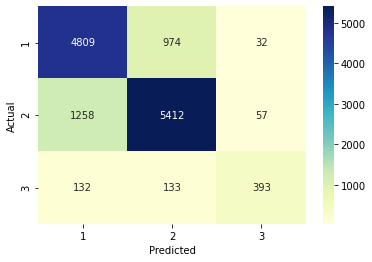

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf = confusion_matrix(y_test_split, ybar)
sns.heatmap(cf, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('heatmap.png')

In [89]:
i = 0
wrong_dict = {1.0:0, 2.0:0, 3.0:0}
while i < len(pred_df):
    pred = pred_df['Predicted labels'].iloc[i]
    actual = pred_df['Actual labels'].iloc[i]
    if pred != actual:
        wrong_dict[actual] += 1
    i += 1

{1.0: 1006, 2.0: 1315, 3.0: 265}

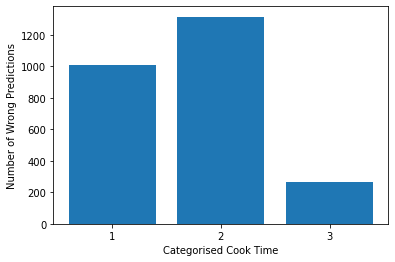

In [90]:
import matplotlib.pyplot as plt
plt.bar(['1', '2', '3'], wrong_dict.values())
plt.xlabel('Categorised Cook Time')
plt.ylabel('Number of Wrong Predictions')
wrong_dict